In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/gimli/projects/igre


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from src.models.ig import information_gain as ig
import scipy.signal as sig
from src.data.dir_dataset import load_all_images as lai

## Load Dataset

In [3]:
pd, metadata = lai('/Users/gimli/Qsync/datasets/Girl with the Pearl Earring/Mh670_2018_X-ray_reflection/wt')
xrpd = pd[0,:,:,:]
f, metadata = lai('/Users/gimli/Qsync/datasets/Girl with the Pearl Earring/MA-XRF')
xrf = f[0,:,:]

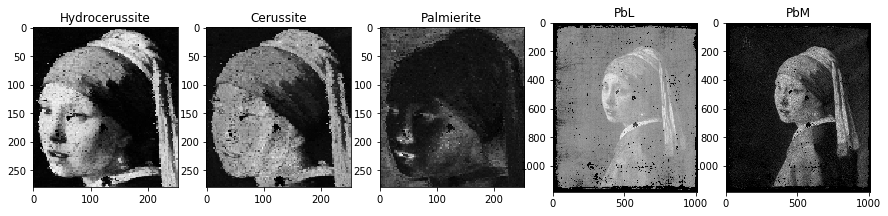

In [4]:
# Check the content
plt.figure(figsize=(15,5))
ax = plt.subplot(1,5,1)
ax.set_title("Hydrocerussite")
ax.imshow(xrpd[:,:,0], cmap="gray")
ax = plt.subplot(1,5,2)
ax.set_title("Cerussite")
ax.imshow(xrpd[:,:,1], cmap="gray")
ax = plt.subplot(1,5,3)
ax.set_title("Palmierite")
ax.imshow(xrpd[:,:,5], cmap="gray")
ax = plt.subplot(1,5,4)
ax.set_title("PbL")
ax.imshow(xrf[:,:,14], cmap="gray")
ax = plt.subplot(1,5,5)
ax.set_title("PbM")
ax.imshow(xrf[:,:,15], cmap="gray")
plt.show()

## Data Registration
- downsample PbL and PbM to XRPD level
- invert transform and prepare upscale transformation

In [5]:
# from src.registration.ga import perspective as p

In [6]:
# p.optimize(xrf[:,:,15], xrpd[:,:,0])

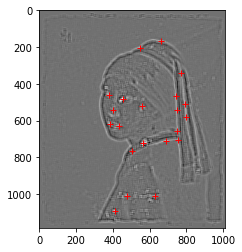

In [7]:
# Compute laplacian of gaussian
LoG = cv2.Laplacian(cv2.blur(xrf[:,:,15], (17,17),0), cv2.CV_32F, 1, 21)
plt.imshow(LoG, cmap="gray")
# sort peaks from the highest
coords1 = np.argsort(LoG.reshape(LoG.shape[0] * LoG.shape[1]))[::-1] 
# Take only limited number of peaks
printed1 = []
for coord in coords1:
    c = np.unravel_index(coord, (xrf.shape[0], xrf.shape[1]))
    # peaks should not be close to each other - the closest printed must be min 50px 
    if not printed1 or np.min([np.linalg.norm(np.array(c) - p) for p in printed1]) > 50:
        printed1.append(np.array(c))
        plt.plot(c[1], c[0], marker="+", color="red")
    if len(printed1) >20:
        break
plt.show()

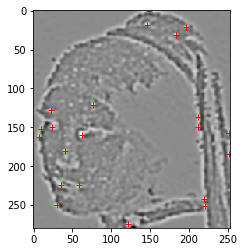

In [8]:
# Do the same for XPRD
# Compute laplacian of gaussian
LoG = cv2.Laplacian(xrpd[:,:,0], cv2.CV_32F, 5, 21)
plt.imshow(LoG, cmap="gray")
# sort them according to peak height
coords2 = np.argsort(LoG.reshape(LoG.shape[0] * LoG.shape[1]))[::-1] 
printed2 = []
for coord in coords2:
    c = np.unravel_index(coord, (LoG.shape[0], LoG.shape[1]))
    # In XRPD is allowed distance 10px
    if not printed2 or np.min([np.linalg.norm(np.array(c) - p) for p in printed2]) > 10:
        printed2.append(np.array(c))
        plt.plot(c[1], c[0], marker="+", color="red")
    if len(printed2) >20:
        break
plt.show()

In [9]:
# Choose the highest and compute angle of all other printed
root1 = np.unravel_index(coords1[0], (xrf.shape[0], xrf.shape[1]))
distances1 = sorted([(p, np.arctan((root1-p)[0]/(root1-p)[1])) for p in printed1[1:]], key=lambda x: x[1])
root2 = np.unravel_index(coords2[0], (xrpd.shape[0], xrpd.shape[1]))
distances2 = sorted([(p, np.arctan((root2-p)[0]/(root2-p)[1])) for p in printed2[1:]], key=lambda x: x[1])

In [10]:
# computed angle error between 2+ LoGs
angle_match = np.zeros((len(distances1), len(distances2)))
for i1, d1 in enumerate(distances1):
    for i2, d2 in enumerate(distances2):
        angle_match[i1, i2] = d1[1]-d2[1] 

In [11]:
# sort angle distance ascending
best_angle_matches = np.argsort(np.abs(angle_match).reshape(len(distances1) * len(distances2)))

# choose 4 best matching coordinates
pts1 = np.zeros((4,2))
pts2 = np.zeros((4,2))
for i, best_angle_match in enumerate(best_angle_matches[:3]):
    idx = np.unravel_index(best_angle_match, (len(distances1), len(distances2)))
    pts1[i+1,:] = distances1[idx[0]][0]
    pts2[i+1,:] = distances2[idx[1]][0]

In [12]:
# set the first peak as the first for registration
pts1[0] = root1
pts2[0] = root2
# flip X and Y axis TODO: check this why
ptsinv1 = np.zeros(pts1.shape)
ptsinv1[:, 0] = pts1[:, 1]
ptsinv1[:, 1] = pts1[:, 0]
ptsinv2 = np.zeros(pts2.shape)
ptsinv2[:, 0] = pts2[:, 1]
ptsinv2[:, 1] = pts2[:, 0]
# and estabilish perspective transformation
M = cv2.getPerspectiveTransform(ptsinv1.astype(np.float32), ptsinv2.astype(np.float32))

At this point we have some rough transformation (if poits are correctly selected). In next few steps we try to take into account all LoGs and use RANSAC/PROSAC method to fix imprecision of the transformation.

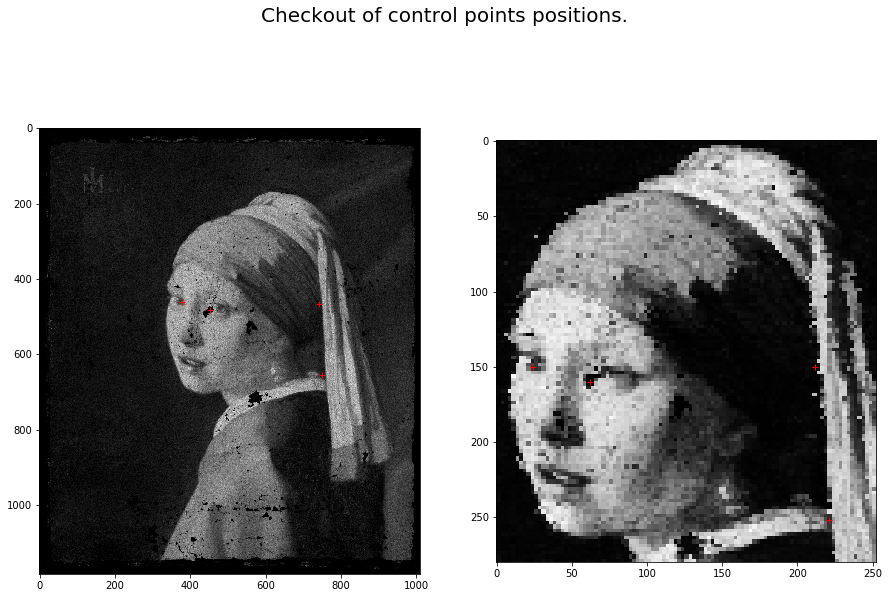

In [28]:
plt.figure(figsize=(15,10))

ax = plt.subplot(1,2,1)
ax.imshow(xrf[:,:,15], cmap="gray")
for i in range(4):
    ax.plot(pts1[i][1], pts1[i][0], color="red", marker="+")

ax = plt.subplot(1,2,2)
ax.imshow(xrpd[:,:,0], cmap="gray")
for i in range(4):
    ax.plot(pts2[i][1], pts2[i][0], color="red", marker="+")

plt.suptitle("Checkout of control points positions.", fontsize=20)
plt.show()

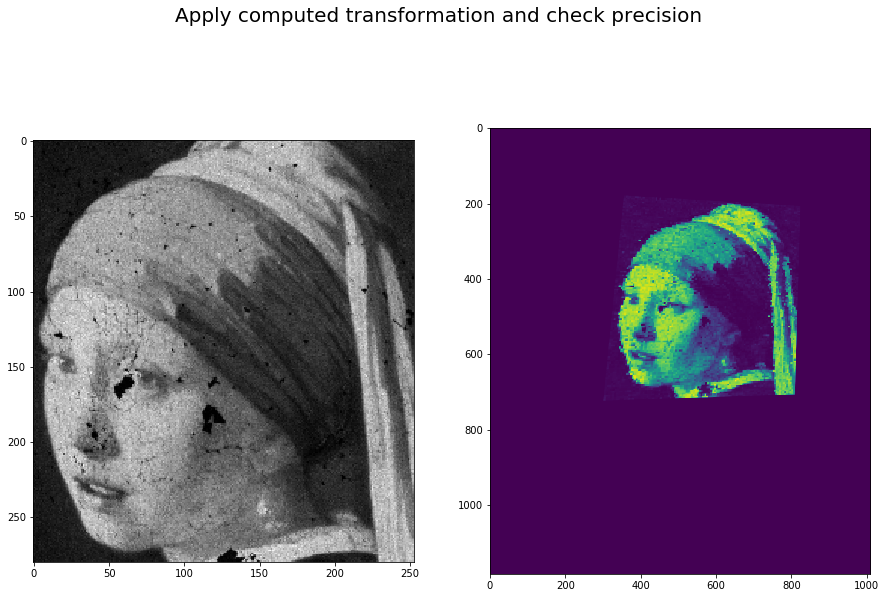

In [29]:
plt.figure(figsize=(15,10))
ax = plt.subplot(1,2,1)
ax.imshow(cv2.warpPerspective(xrf[:,:,15], M, (xrpd.shape[1], xrpd.shape[0])), cmap="gray")
ax = plt.subplot(1,2,2)
ax.imshow(cv2.warpPerspective(xrpd[:,:,0], np.linalg.inv(M), (xrf.shape[1], xrf.shape[0])))
plt.suptitle("Apply computed transformation and check precision", fontsize=20)
plt.show()

In [15]:
# This is perspective transformation equation
def transform_vec(M, v):
    denom = (M[2,0] * v[1] + M[2,1] * v[0] + M[2,2])
    return (M[0,0] * v[1] + M[0,1] * v[0] + M[0,2]) / denom, \
           (M[1,0] * v[1] + M[1,1] * v[0] + M[1,2]) / denom 

- take LoGs from XRF and transform them into XRPD
- find out closest XRPD LoGs to match predicted ...

In [16]:
LoG = cv2.Laplacian(cv2.blur(xrf[:,:,15], (17,17),0), cv2.CV_32F, 1, 21)
candidates = [(transform_vec(M, np.unravel_index(idx, (LoG.shape[0], LoG.shape[1]))), 
              np.unravel_index(idx, (LoG.shape[0], LoG.shape[1]))) 
                  for idx in np.argsort(np.abs(LoG.reshape(LoG.shape[0] * LoG.shape[1])))[::-1][:3000]]

In [17]:
filtered = []
origs = []
for candidate, orig in candidates:
    if (not filtered or np.min([np.linalg.norm(np.array(f)-np.array(candidate)) for f in filtered]) > 30) \
        and xrpd.shape[0] > candidate[0] > 0 \
        and xrpd.shape[1] > candidate[1] > 0:
        filtered.append(candidate)
        origs.append(orig)

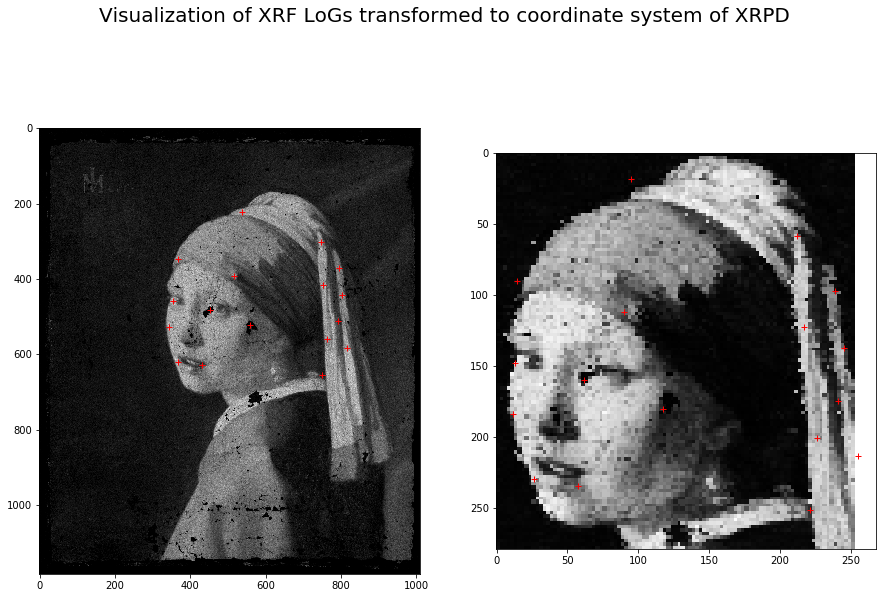

In [30]:
plt.figure(figsize=(15,10))
ax = plt.subplot(1,2,1)
ax.imshow(xrf[:,:,15], cmap="gray")
for orig in origs:
    ax.plot(orig[1], orig[0], color="red", marker="+")

ax = plt.subplot(1,2,2)
ax.imshow(xrpd[:,:,0], cmap="gray")
for i in range(len(filtered)):
    ax.plot(filtered[i][0], filtered[i][1], color="red", marker="+")

plt.suptitle("Visualization of XRF LoGs transformed to coordinate system of XRPD", fontsize=20)
plt.show()

In [19]:
pd_logs = [(np.unravel_index(coord, (xrpd.shape[0], xrpd.shape[1]))[1],
 np.unravel_index(coord, (xrpd.shape[0], xrpd.shape[1]))[0]) for coord in coords2]

In [20]:
filtered_match = []
for est in filtered:
    for coord in pd_logs:
        if np.linalg.norm(np.array(coord)-np.array(est)) < 20:
            filtered_match.append(coord)
            break

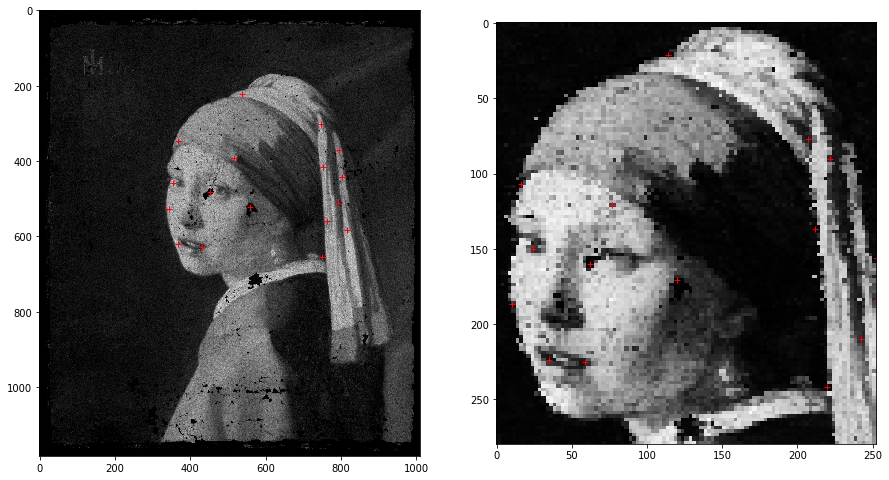

In [21]:
plt.figure(figsize=(15,10))
ax = plt.subplot(1,2,1)
ax.imshow(xrf[:,:,15], cmap="gray")
for orig in origs:
    ax.plot(orig[1], orig[0], color="red", marker="+")

ax = plt.subplot(1,2,2)
ax.imshow(xrpd[:,:,0], cmap="gray")
for coord in filtered_match:
    ax.plot(coord[0], coord[1], color="red", marker="+")

plt.show()

Now we have coordinates pairs and we can go to RANSAC fit. The same we can repeate:
- transform LoGs from XRF to XRPD
- find closest XRPD LoGs and create pairs
- run RANSAC to minimize error of perspective transformation

In [58]:
point_pairs = np.array([[o, m] for o, m in zip(origs, filtered_match)]).astype(np.float32)

In [80]:
def get_model(data):
    rnd = np.random.randint(data.shape[0], size=(4,))
    return cv2.getPerspectiveTransform(data[rnd,0,:], data[rnd,1,:])

def get_score(data, model):
    return np.sum([
        np.linalg.norm(transform_vec(model, data[d,0,:]) - data[d,1,:])
        for d in range(data.shape[0])
    ])
    

In [81]:
m0 = get_model(point_pairs.astype(np.float32))

In [82]:
min_error = get_score(point_pairs.astype(np.float32), m0)

In [83]:
for i in range(60000):
    model = get_model(point_pairs)
    error = get_score(point_pairs, model)
    if error < min_error:
        min_error = error
        m0 = model
        print(f"err:{min_error}")
print("Model:")
print(m0)

err:2002.0619051096792
err:1977.7374873780661
err:1391.650679244654
err:1361.1560807447356
err:1191.3796671780253
err:1110.8185981872284
Model:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]


In [95]:
[transform_vec(m0, point_pairs[p,0,:]) - point_pairs[p,1,:] for p in range(point_pairs.shape[0])]

[array([ 53.21371374, -20.37985918]),
 array([  41.15229005, -117.73034303]),
 array([54.56269092, -9.12460867]),
 array([-13.04800742,  39.08183626]),
 array([-39.51715364,  24.69438703]),
 array([  3.00458428, -20.65649857]),
 array([ 37.04407864, -51.48264645]),
 array([-26.78318064,  -0.27625444]),
 array([ -3.99947074, 126.27713892]),
 array([-23.87406493,  86.85925757]),
 array([  7.31085578, -42.77146019]),
 array([17.4483956 ,  7.72454069]),
 array([-28.81583609,  93.77672962]),
 array([ -9.89410936, -25.31419392]),
 array([51.03468846, 28.19503971]),
 array([ 16.85099593, -88.56248996]),
 array([ 85.91943628, -87.00887089])]

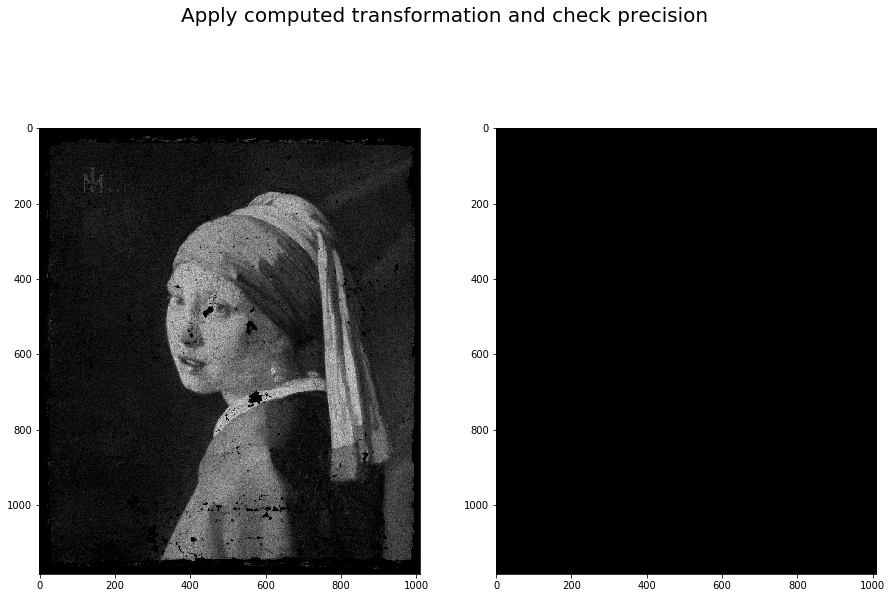

In [90]:
plt.figure(figsize=(15,10))
ax = plt.subplot(1,2,1)
ax.imshow(xrf[:,:,15], cmap="gray")
ax = plt.subplot(1,2,2)
ax.imshow(cv2.warpPerspective(xrpd[:,:,0], m0, (xrf.shape[1], xrf.shape[0])), cmap="gray")
plt.suptitle("Apply computed transformation and check precision", fontsize=20)
plt.show()